In [103]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. ENVIRONMENT: Windy Gridworld (Based on Example 6.5) ---

class WindyGrid:
    def __init__(self, rows=7, cols=10, start=(3, 0), goal=(3, 7)):
        self.rows = rows
        self.cols = cols
        self.start_state = start
        self.goal_state = goal
        self.current_state = start
        self.is_game_over = False

        # Wind strength for each column (0-indexed)
        self.wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

        self.actions = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}
        self.all_possible_actions = ('U', 'D', 'L', 'R')

    def reset(self):
        self.current_state = self.start_state
        self.is_game_over = False
        return self.current_state

    def is_terminal(self, s):
        return s == self.goal_state

    def game_over(self):
        return self.is_game_over

    def get_state(self):
        return self.current_state

    def move(self, action):
        if self.is_game_over:
            return 0.0

        r, c = self.current_state
        dr, dc = self.actions[action]

        # Apply action
        r_new, c_new = r + dr, c + dc
        # Apply wind
        wind_strength = self.wind[c_new] if 0 <= c_new < self.cols else 0
        r_new -= wind_strength

        # Boundary checks
        r_new = max(0, min(self.rows - 1, r_new))
        c_new = max(0, min(self.cols - 1, c_new))
        self.current_state = (r_new, c_new)

        # Reward
        if self.current_state == self.goal_state:
            self.is_game_over = True
            return 0.0
        else:
            return -1.0

    def all_states(self):
        return [(r, c) for r in range(self.rows) for c in range(self.cols)]




In [104]:
# --- 2. EXPLORATION and HELPERS ---

ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

def max_dict(d):
    if not d:
        return np.random.choice(ALL_POSSIBLE_ACTIONS), 0.0
    max_val = max(d.values())
    max_keys = [k for k, v in d.items() if v == max_val]
    return np.random.choice(max_keys), max_val


def epsilon_greedy(Q, s, eps):
    """
    Performs epsilon-greedy action selection.
    """
    if s not in Q or not Q[s]:
        # case where state 's' is not yet in Q or Q[s] is empty
        return np.random.choice(ALL_POSSIBLE_ACTIONS)
    if np.random.rand() < eps:
        # Exploration: Select a random action from the actions available in this state
        # Should select a random action with probability 'eps'
        return np.random.choice(ALL_POSSIBLE_ACTIONS)
    else:
        # Exploitation: Select the greedy action (using max_dict)
        # the greedy action (using max_dict) with probability '1 - eps'.
        return max_dict(Q[s])[0]


def ucb_exploration(Q, N, s, c, t):
    """
    Performs UCB (Upper Confidence Bound) action selection.
    Q: action-value function dictionary
    N: visit count dictionary for (state, action) pairs
    s: current state
    c: exploration constant
    t: current time step (or total step count)
    Q(s, a) + c * sqrt(log(t) / N(s, a))
    """
    # ucb_exploration function
    if s not in Q or not Q[s]: return np.random.choice(ALL_POSSIBLE_ACTIONS)

    # Select unvisited actions if they exist (N(s, a) = 0).
    unvisited = [a for a in ALL_POSSIBLE_ACTIONS if N.get((s, a), 0) == 0]
    if unvisited:
        return np.random.choice(unvisited)

    # Otherwise, compute UCB value: Q(s, a) + c * sqrt(log(t) / N(s, a))
    ucb_vals = {}
    # Compute UCB values for each action
    # Ensures log(t) is defined and > 0. t starts at 1 in run_control.
    log_t = np.log(t)

    for a in ALL_POSSIBLE_ACTIONS:
        n_sa = N[(s, a)]
        # UCB formula
        ucb_value = Q[s][a] + c * np.sqrt(log_t / n_sa)
        ucb_vals[a] = ucb_value

    # Select action with max UCB value (max_dict handles ties randomly)
    return max_dict(ucb_vals)[0]
    # Select action with max UCB value.




In [105]:
# --- 3. UPDATE RULES ---

def sarsa_update(Q, s, a, r, s2, a2, gamma, alpha, grid):
    """
    Performs SARSA update.
    Q(s, a) <- Q(s, a) + alpha * [r + gamma * Q(s2, a2) - Q(s, a)]
    """
    # Implement sarsa_update function
    # Remember Q(s2, a2) is 0 if s2 is terminal (goal state).
    # Also remmber the correct update equation and implement it here.
    old_q = Q[s][a]

    # Target value: Q(s2, a2) is 0 if s2 is terminal
    if grid.is_terminal(s2):
        q_s2_a2 = 0.0
    else:
        # Q(s2, a2). Assumes Q[s2][a2] is 0.0 if not yet initialized/visited
        q_s2_a2 = Q.get(s2, {}).get(a2, 0.0)

    # Target calculation: R + gamma * Q(s2, a2)
    target = r + gamma * q_s2_a2

    # SARSA Update
    Q[s][a] = old_q + alpha * (target - old_q)

    return Q

def q_learning_update(Q, s, a, r, s2, _a2, gamma, alpha, grid):
    """
    Performs q_learning update.
     Q(s, a) <- Q(s, a) + alpha * [r + gamma * max_a' Q(s2, a') - Q(s, a)]
    """
    old_q = Q[s][a]
     # Find max_q_s2 = max_a' Q(s2, a')
    if grid.is_terminal(s2):
      max_q_s2 = 0.0 # Placeholder
    else:
        # Get the max Q-value for s2. max_dict returns 0.0 if s2 is uninitialized.
        max_q_s2 = max_dict(Q.get(s2, {}))[1]

    # Target calculation: R + gamma * max_a' Q(s2, a')
    target = r + gamma * max_q_s2

    # Q-Learning Update
    Q[s][a] = old_q + alpha * (target - old_q)
    # Remeber to correctly choose max_q_s2, No hints given
    # Also remmber the correct update equation and implement it here.
    return Q

def expected_q_learning_update(Q, s, a, r, s2, a2, gamma, alpha, grid, eps=0.2):
    """
    Performs Expected SARSA (Expected Q-Learning) update.
    Q(s, a) <- Q(s, a) + alpha * [r + gamma * E[Q(s2, A)] - Q(s, a)]
    where E[Q(s2, A)] is the expected value under the epsilon-greedy policy:

    Let 'n' be the number of possible actions.
    Let 'a*' be the greedy action for state s2: a* = argmax_a Q(s2, a)

    The policy pi(a | s2) is defined as:
    pi(a* | s2) = pi_star = 1 - eps + eps / n
    pi(a | s2) = pi_other = eps / n   (for a != a*)

    E[Q(s2, A)] = sum_a pi(a | s2) * Q(s2, a)
    """

    old_q = Q[s][a]

    if grid.is_terminal(s2):
        expected_q_s2 = 0.0
    else:
        # Ensure s2 is in Q (it should be, but defensive check)
        if s2 not in Q:
            Q[s2] = {act: 0.0 for act in ALL_POSSIBLE_ACTIONS}

        expected_q_s2 = 0.0
        n_actions = len(ALL_POSSIBLE_ACTIONS)

        # 1. Find the greedy action value
        a_star, q_a_star = max_dict(Q[s2])

        # 2. Compute probabilities under epsilon-greedy policy
        # Probability for the greedy action
        pi_star = 1.0 - eps + eps / n_actions
        # Probability for all other actions
        pi_other = eps / n_actions

        # 3. Compute Expected Q-value E[Q(s2, A)]
        # Add the contribution of all actions
        for action in Q[s2].keys():
            q_value = Q[s2].get(action, 0.0)
            if action == a_star:
                expected_q_s2 += pi_star * q_value
            else:
                expected_q_s2 += pi_other * q_value

    # Perform the update
    target = r + gamma * expected_q_s2
    Q[s][a] = old_q + alpha * (target - old_q)

    return Q

def double_q_learning_update(QA, QB, s, a, r, s2, a2, gamma, alpha, grid):
    """
    Performs Double Q-Learning update.
    Randomly chooses QA or QB to update and uses the other for target selection.

    Let Q_upd be the Q-table chosen for the update (either QA or QB).
    Let Q_sel be the other Q-table used for value selection.

    The update rule for Q_upd is:
    Q_upd(s, a) <- Q_upd(s, a) + alpha * [r + gamma * Q_sel(s2, argmax_a' Q_upd(s2, a')) - Q_upd(s, a)]

    If s2 is terminal, the target is simply r.
    """
    # Implement double_q_learning_update function
    # Randomly choose Q_upd (the one to update) and Q_sel (the one for selection).

    Q_upd, Q_sel = None, None # Initialize Q_upd, Q_sel correctly here)
    updated_is_QA = None # Initialize a flag to check if QA was updated or QB
    if s not in QA:
      QA[s] = {act:0.0 for act in ALL_POSSIBLE_ACTIONS}
    if s not in QB:
      QB[s] = {act:0.0 for act in ALL_POSSIBLE_ACTIONS}
    if s2 not in QA:
      QA[s2] = {act:0.0 for act in ALL_POSSIBLE_ACTIONS}
    if s2 not in QA:
      QA[s2] = {act:0.0 for act in ALL_POSSIBLE_ACTIONS}

    if np.random.rand() < 0.5:
        # implements the random selection of Q_upd and Q_sel
        Q_upd, Q_sel = QA, QB
        updated_is_QA = True
    else:
        # implements the random selection of Q_upd and Q_sel
        Q_upd, Q_sel = QB, QA
        updated_is_QA = False

    # Calculate the target (Read the docstring carefully)
    if grid.is_terminal(s2):
        target = r
    else:
        # Selection step: a* = argmax_a' Q_upd(s2, a')
        # Use Q_upd to find the best action at s2
        if s2 not in Q_upd:
            Q_upd[s2] = {act: 0.0 for act in ALL_POSSIBLE_ACTIONS}
        if s2 not in Q_sel:
            Q_sel[s2] = {act: 0.0 for act in ALL_POSSIBLE_ACTIONS}
        a_star, _ = max_dict(Q_upd[s2])

        # Evaluation step: Q_sel(s2, a*)
        # Use Q_sel to evaluate the value of the action chosen by Q_upd
        q_s2_a_star = Q_sel[s2].get(a_star, 0.0)

        target = r + gamma * q_s2_a_star

    # Perform the update for Q_upd
    old_q = Q_upd[s][a]
    old_q = Q_upd[s].get(a, 0.0)
    Q_upd[s][a] = old_q + alpha * (target - old_q)

    # return the correct (QA, QB) tuple based on which was updated

    if updated_is_QA:
        return Q_upd, Q_sel
    else:
        return Q_sel, Q_upd




In [106]:
# --- 3. UPDATE RULES ---

def sarsa_update(Q, s, a, r, s2, a2, gamma, alpha, grid):
    """
    Performs SARSA update.
    Q(s, a) <- Q(s, a) + alpha * [r + gamma * Q(s2, a2) - Q(s, a)]
    """
    # Implement sarsa_update function
    # Remember Q(s2, a2) is 0 if s2 is terminal (goal state).
    # Also remmber the correct update equation and implement it here.
    old_q = Q[s][a]

    # Target value: Q(s2, a2) is 0 if s2 is terminal
    if grid.is_terminal(s2):
        q_s2_a2 = 0.0
    else:
        # Q(s2, a2). Assumes Q[s2][a2] is 0.0 if not yet initialized/visited
        q_s2_a2 = Q.get(s2, {}).get(a2, 0.0)

    # Target calculation: R + gamma * Q(s2, a2)
    target = r + gamma * q_s2_a2

    # SARSA Update
    Q[s][a] = old_q + alpha * (target - old_q)
    return Q

def q_learning_update(Q, s, a, r, s2, _a2, gamma, alpha, grid):
    """
    Performs q_learning update.
     Q(s, a) <- Q(s, a) + alpha * [r + gamma * max_a' Q(s2, a') - Q(s, a)]
    """
    old_q = Q[s][a]
     # Find max_q_s2 = max_a' Q(s2, a')
    if grid.is_terminal(s2):
      max_q_s2 = 0.0 # Placeholder
    else:
        # Get the max Q-value for s2. max_dict returns 0.0 if s2 is uninitialized.
        max_q_s2 = max_dict(Q.get(s2, {}))[1]

    # Target calculation: R + gamma * max_a' Q(s2, a')
    target = r + gamma * max_q_s2

    # Q-Learning Update
    Q[s][a] = old_q + alpha * (target - old_q)
    # Remeber to correctly choose max_q_s2, No hints given
    # Also remmber the correct update equation and implement it here.
    return Q

def expected_q_learning_update(Q, s, a, r, s2, a2, gamma, alpha, grid, eps=0.2):
    """
    Performs Expected SARSA (Expected Q-Learning) update.
    Q(s, a) <- Q(s, a) + alpha * [r + gamma * E[Q(s2, A)] - Q(s, a)]
    where E[Q(s2, A)] is the expected value under the epsilon-greedy policy:

    Let 'n' be the number of possible actions.
    Let 'a*' be the greedy action for state s2: a* = argmax_a Q(s2, a)

    The policy pi(a | s2) is defined as:
    pi(a* | s2) = pi_star = 1 - eps + eps / n
    pi(a | s2) = pi_other = eps / n   (for a != a*)

    E[Q(s2, A)] = sum_a pi(a | s2) * Q(s2, a)
    """

    old_q = Q[s][a]

    if grid.is_terminal(s2):
        expected_q_s2 = 0.0
    else:
        # Ensure s2 is in Q (it should be, but defensive check)
        if s2 not in Q:
            Q[s2] = {act: 0.0 for act in ALL_POSSIBLE_ACTIONS}

        expected_q_s2 = 0.0
        n_actions = len(ALL_POSSIBLE_ACTIONS)

        # 1. Find the greedy action value
        a_star, q_a_star = max_dict(Q[s2])

        # 2. Compute probabilities under epsilon-greedy policy
        # Probability for the greedy action
        pi_star = 1.0 - eps + eps / n_actions
        # Probability for all other actions
        pi_other = eps / n_actions

        # 3. Compute Expected Q-value E[Q(s2, A)]
        # Add the contribution of all actions
        for action in Q[s2].keys():
            q_value = Q[s2].get(action, 0.0)
            if action == a_star:
                expected_q_s2 += pi_star * q_value
            else:
                expected_q_s2 += pi_other * q_value

    # Perform the update
    target = r + gamma * expected_q_s2
    Q[s][a] = old_q + alpha * (target - old_q)

    return Q

def double_q_learning_update(QA, QB, s, a, r, s2, a2, gamma, alpha, grid):
    """
    Performs Double Q-Learning update.
    Randomly chooses QA or QB to update and uses the other for target selection.

    Let Q_upd be the Q-table chosen for the update (either QA or QB).
    Let Q_sel be the other Q-table used for value selection.

    The update rule for Q_upd is:
    Q_upd(s, a) <- Q_upd(s, a) + alpha * [r + gamma * Q_sel(s2, argmax_a' Q_upd(s2, a')) - Q_upd(s, a)]

    If s2 is terminal, the target is simply r.
    """
    # Implement double_q_learning_update function
    # Randomly choose Q_upd (the one to update) and Q_sel (the one for selection).

    Q_upd, Q_sel = None, None # Initialize Q_upd, Q_sel correctly here)
    updated_is_QA = None # Initialize a flag to check if QA was updated or QB
    if s not in QA:
      QA[s] = {act:0.0 for act in ALL_POSSIBLE_ACTIONS}
    if s not in QB:
      QB[s] = {act:0.0 for act in ALL_POSSIBLE_ACTIONS}
    if s2 not in QA:
      QA[s2] = {act:0.0 for act in ALL_POSSIBLE_ACTIONS}
    if s2 not in QA:
      QA[s2] = {act:0.0 for act in ALL_POSSIBLE_ACTIONS}

    if np.random.rand() < 0.5:
        Q_upd, Q_sel = QA, QB
        updated_is_QA = True
        #print('implements the random selection of Q_upd and Q_sel')
    else:
        Q_upd, Q_sel = QB, QA
        updated_is_QA = False
        #print('implements the random selection of Q_upd and Q_sel')


    # Calculate the target (Read the docstring carefully)
    if grid.is_terminal(s2):
        target = r
    else:
        # Selection step: a* = argmax_a' Q_upd(s2, a')
        # Use Q_upd to find the best action at s2
        if s2 not in Q_upd:
            Q_upd[s2] = {act: 0.0 for act in ALL_POSSIBLE_ACTIONS}
        if s2 not in Q_sel:
            Q_sel[s2] = {act: 0.0 for act in ALL_POSSIBLE_ACTIONS}
        a_star, _ = max_dict(Q_upd[s2])

        # Evaluation step: Q_sel(s2, a*)
        # Use Q_sel to evaluate the value of the action chosen by Q_upd
        q_s2_a_star = Q_sel[s2].get(a_star, 0.0)

        target = r + gamma * q_s2_a_star

    # Perform the update for Q_upd
    old_q = Q_upd[s][a]
    old_q = Q_upd[s].get(a, 0.0)
    Q_upd[s][a] = old_q + alpha * (target - old_q)

    # return the correct (QA, QB) tuple based on which was updated
    if updated_is_QA:
        return Q_upd, Q_sel
    else:
        return Q_sel, Q_upd




In [107]:
# --- 4. CONTROL LOOP ---
def run_control(grid, Q_init, N_init, n_episodes, alpha, gamma,
                algorithm_name, exploration_type, **kwargs):
    np.random.seed(0)

    # Initialize Q-tables
    ALL_STATES = grid.all_states() # Include all states, including the goal state
    #  Get all states from the grid environment (except the terminal/goal state)
    Q1 = {s: {a: Q_init.get((s, a), 0.0) for a in ALL_POSSIBLE_ACTIONS}
          for s in ALL_STATES}
    Q2 = None

    is_double_q = (algorithm_name == "Double Q-Learning")
    if is_double_q:
        # Initialize Q2 to all 0.0 values for all states and actions
         Q2 = {s: {a: 0.0 for a in ALL_POSSIBLE_ACTIONS} for s in ALL_STATES}

    N = N_init.copy()
    # Function to choose the appropriate update function DO NOT CHANGE
    update_fn = {
        'SARSA': sarsa_update,
        'Q-Learning': q_learning_update,
        'Expected Q-Learning': expected_q_learning_update,
        'Double Q-Learning': double_q_learning_update
    }[algorithm_name]

    # ---------DO NOT CHANGE--------
    eps = kwargs.get('eps', 0.2)
    c = kwargs.get('c', 2)

    t = 1  # Total time step counter for UCB
    # ---------DO NOT CHANGE-----
    n_episodes = kwargs.get('episodes', 200)
    gamma = kwargs.get('l_gamma', 1)

    # Helper function to get the primary Q-table for exploration
    def get_exploration_Q():
        return Q1

    # Helper function for action selection
    def select_action(state, current_t):
        Q_explore = get_exploration_Q()
        # Implement action selection based on exploration_type
        # USe the exploration functions defined earlier
        if exploration_type == 'Epsilon-greedy':
            return epsilon_greedy(Q_explore, state, eps)
        elif exploration_type == 'UCB':
            # UCB uses the global time step 't'
            return ucb_exploration(Q_explore, N, state, c, current_t)
        else:
            raise ValueError(f"Unknown exploration type: {exploration_type}")


    # --- Main Control Loop ---
    for _ in range(n_episodes):
        s = grid.reset()
        a = select_action(s, t) # Initial action selection

        while not grid.game_over():
            r = grid.move(a)
            #s2 = None #  Get the next state from the grid
            s2 = grid.get_state()

            # Select the next action (a2)
            #a2 = None #  Select the next action using the select_action function
            a2 = select_action(s2, t)

            t += 1
            N[(s, a)] = N.get((s, a), 0) + 1

            # --- Q-Table Update ---
            if is_double_q:
                # Double Q-Learning update
                # Call the appropriate update function and update Q1, Q2
                Q1, Q2 = update_fn(Q1, Q2, s, a, r, s2, a2, gamma, alpha, grid)

            else:
                # Single Q-Table Algorithm update
                if algorithm_name == "Expected Q-Learning":
                    # Call the appropriate function and update Q1
                    Q1 = update_fn(Q1, s, a, r, s2, a2, gamma, alpha, grid, eps=eps)
                else:
                    # SARSA or Q-Learning update
                    # Call the appropriate update function and update Q1
                    Q1 = update_fn(Q1, s, a, r, s2, a2, gamma, alpha, grid)

            # Move to the next state-action pair
            s, a = s2, a2

    # Return the correct Q-table(s) based on method used {single or double Q-learning}
    if is_double_q:
        return Q1, Q2
    else:
        return Q1

In [108]:
# --- 5. PATH TRACING and PLOTTING ---

def trace_optimal_path(Q, grid):
    s = grid.start_state
    path = [s]
    steps = 0
    max_steps = grid.rows * grid.cols * 10

    while s != grid.goal_state and steps < max_steps:
        #a = max_dict(Q.get(s, {}))[0]
        # Defensive check: if state is not in Q (or has no actions), choose randomly.
        #if s not in Q or not Q[s]:
        #    a = np.random.choice(ALL_POSSIBLE_ACTIONS)
        #else:
        a = max_dict(Q[s])[0]
        # Defensive check:
        r, c = s
        dr, dc = grid.actions[a]
        r_new, c_new = r + dr, c + dc
        wind = grid.wind[c_new] if 0 <= c_new < grid.cols else 0
        r_new -= wind
        r_new = max(0, min(grid.rows - 1, r_new))
        c_new = max(0, min(grid.cols - 1, c_new))
        s_next = (r_new, c_new)
        if (s_next == s and steps > 0) or path.count(s_next) > 1:
            break
        path.append(s_next)
        s = s_next
        steps += 1

    return path, steps

def plot_path(grid, path, title, ax):
    ax.set_xlim(-0.5, grid.cols - 0.5)
    ax.set_ylim(grid.rows - 0.5, -0.5)
    ax.set_xticks(np.arange(-0.5, grid.cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, grid.rows, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    ax.tick_params(which='minor', size=0)
    ax.tick_params(labelbottom=False, labelleft=False)

    ax.text(grid.start_state[1], grid.start_state[0], 'S',
            ha='center', va='center', color='green', fontsize=16, weight='bold')
    ax.text(grid.goal_state[1], grid.goal_state[0], 'G',
            ha='center', va='center', color='red', fontsize=16, weight='bold')

    for c, w in enumerate(grid.wind):
        if w > 0:
            color = 'lightblue' if w == 1 else 'skyblue'
            ax.add_patch(plt.Rectangle((c - 0.5, -0.5), 1, grid.rows,
                         color=color, alpha=0.3))

    coords = np.array(path)
    if coords.shape[0] > 1 and path[-1] == grid.goal_state:
        ax.plot(coords[:, 1], coords[:, 0], 'o-', color='purple',
                markersize=5, linewidth=2)
        ax.set_title(title, fontsize=10)
    elif coords.shape[0] > 1:
        ax.plot(coords[:, 1], coords[:, 0], 'o--', color='orange',
                markersize=5, linewidth=2)
        ax.set_title(f"{title}\n(Path terminated, Goal NOT reached)", fontsize=10)
    else:
        ax.set_title(f"{title}\n(Path not found)", fontsize=10)



Running: a) SARSA, ε-greedy...
Running: b) SARSA, UCB...
Running: c) Q-Learning, ε-greedy...
Running: d) Q-Learning, UCB...
Running: e) Exp. Q-Learning, ε-greedy...
Running: f) Exp. Q-Learning, UCB...
Running: g) Double Q-Learning, ε-greedy...
Running: h) Double Q-Learning, UCB...


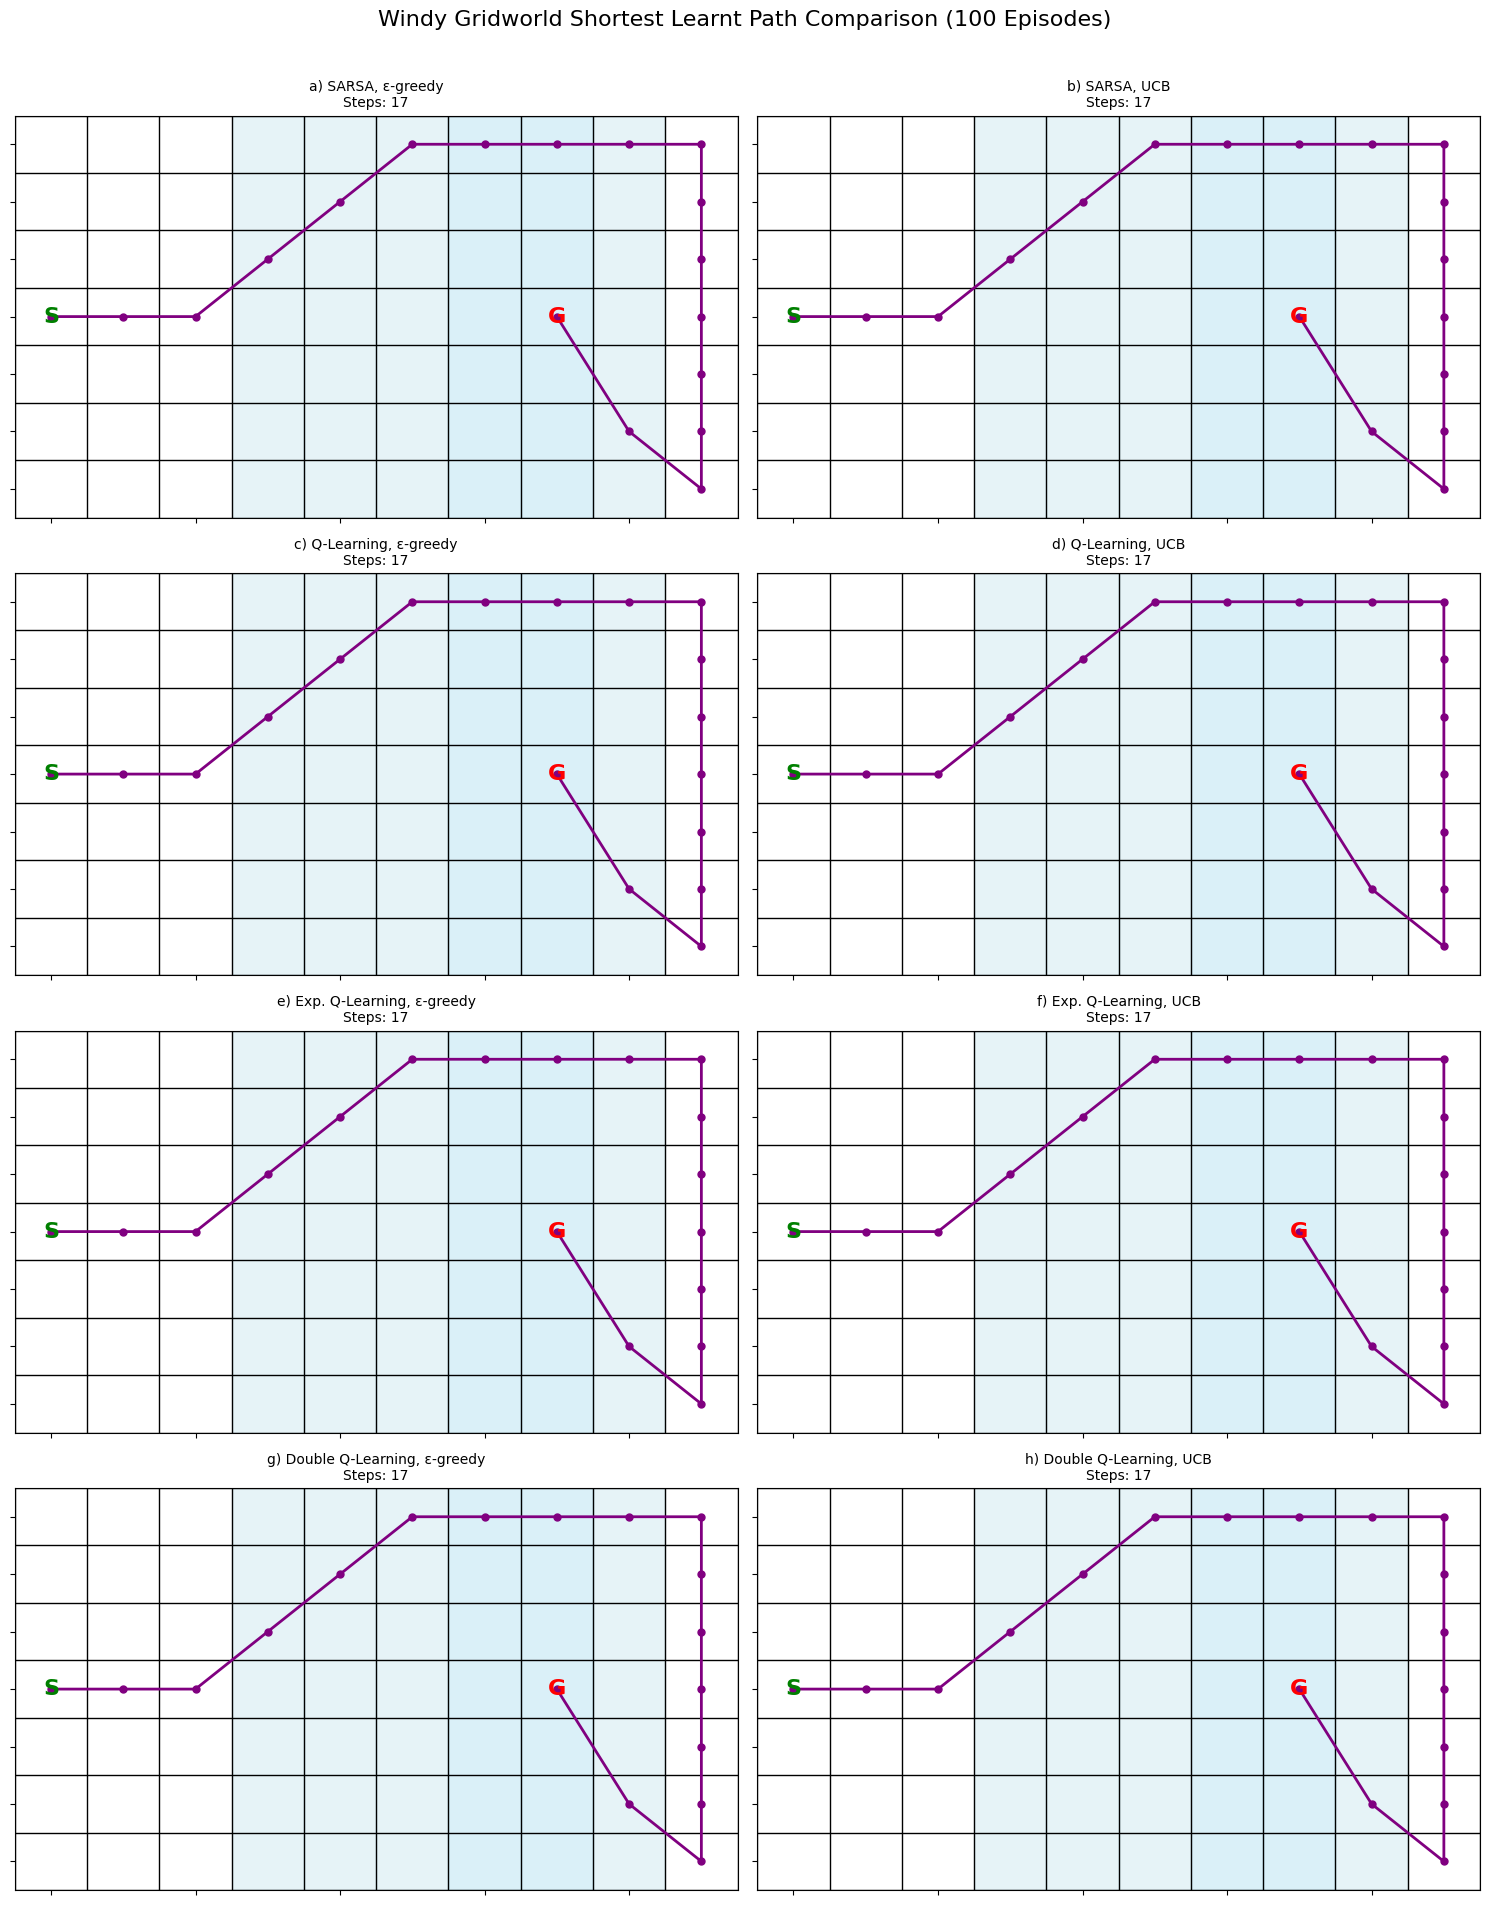


Shortest Path Results After 500 Episodes
Algorithm                      |  Steps in Shortest Learnt Path
---------------------------------------------------------------
a) SARSA, ε-greedy             |                             17
b) SARSA, UCB                  |                             17
c) Q-Learning, ε-greedy        |                             17
d) Q-Learning, UCB             |                             17
e) Exp. Q-Learning, ε-greedy   |                             17
f) Exp. Q-Learning, UCB        |                             17
g) Double Q-Learning, ε-greedy |                             17
h) Double Q-Learning, UCB      |                             17


In [112]:
# --- 6. MAIN EXECUTION ---

def run_all_experiments():
    N_EPISODES = 100
    ALPHA = 0.5
    #ALPHA_DOUBLE_Q = 0.997
    GAMMA = 1
    EPSILON = 0.2
    UCB_C = 4

    grid = WindyGrid()
    results = {}

    experiments = [
        ("a) SARSA, ε-greedy", 'SARSA', 'Epsilon-greedy', {'eps': 0.05,'episodes':200}),
        ("b) SARSA, UCB", 'SARSA', 'UCB', {'c': 2, 'episodes':200}),
        ("c) Q-Learning, ε-greedy", 'Q-Learning', 'Epsilon-greedy', {'eps': 0.05,'episodes':100}),
        ("d) Q-Learning, UCB", 'Q-Learning', 'UCB', {'c': 2,'episodes':200}),
        ("e) Exp. Q-Learning, ε-greedy", 'Expected Q-Learning', 'Epsilon-greedy', {'eps': 0.05,'episodes':100}),
        ("f) Exp. Q-Learning, UCB", 'Expected Q-Learning', 'UCB', {'c': 2,'episodes':200}),
        ("g) Double Q-Learning, ε-greedy", 'Double Q-Learning', 'Epsilon-greedy', {'eps': 0.05, 'episodes':500}),
        ("h) Double Q-Learning, UCB", 'Double Q-Learning', 'UCB', {'c': 2, 'episodes':1500, 'l_gamma':0.8}),
    ]

    Q_init = {}
    N_init = {}

    for name, alg, exp_type, params in experiments:
        print(f"Running: {name}...")
        Q_final = run_control(
            grid=grid,
            Q_init=Q_init,
            N_init=N_init,
            n_episodes=N_EPISODES,
            alpha=ALPHA,
            gamma=GAMMA,
            algorithm_name=alg,
            exploration_type=exp_type,
            **params
        )
        if isinstance(Q_final, tuple):
            Q1, Q2 = Q_final
            Q_for_path = {
                s: {a: 0.5 * (Q1[s][a] + Q2[s][a]) for a in ALL_POSSIBLE_ACTIONS}
                for s in Q1
            }
        else:
            Q_for_path = Q_final

        path, steps = trace_optimal_path(Q_for_path, grid)
        results[name] = {'path': path, 'steps': steps}

    fig, axes = plt.subplots(4, 2, figsize=(15, 20))
    axes = axes.flatten()
    for i, (name, data) in enumerate(results.items()):
        plot_path(grid, data['path'], f"{name}\nSteps: {data['steps']}", axes[i])

    fig.suptitle(f"Windy Gridworld Shortest Learnt Path Comparison ({N_EPISODES} Episodes)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

    print("\n" + "="*50)
    print("Shortest Path Results After 500 Episodes")
    print("="*50)
    print(f"{'Algorithm':<30} | {'Steps in Shortest Learnt Path':>30}")
    print("-" * 63)
    for name, data in results.items():
        print(f"{name:<30} | {data['steps']:>30}")


if __name__ == '__main__':
    run_all_experiments()


**The purpose of the experiment**
 To perform a direct comparison of several core Reinforcement Learning (RL) control algorithms and their respective exploration strategies within the challenging Windy Gridworld environment.


**SARSA with Epsilon Greedy**:
Agent finds the goal state with below epsilon, num of episode
18 step - (0.1, 200), (0.2, 200)
17 step - (0.05, 200), (0.1, 400), (0.2, 600)


**Double Q-Learning with UCB**: Agent finds the goal state with below (ucb, num of episode, gamma) 17 step - (2, 1500, 0.8), (4, 1500, 1), though it can reach goal state in 18 step - (2, 1000, 0.9)